Metode yang Digunakan

Pada tugas pertama, saya menggunakan LightGBM (Light Gradient Boosting Machine) dengan teknik:
1. Gradient Boosting Decision Trees (GBDT)
2. Early Stopping
3. Train/Validation Split
4. AUC sebagai metrik evaluasi

Model LightGBM yang kamu buat digunakan untuk klasifikasi biner → memprediksi apakah transaksi adalah fraud atau tidak fraud (isFraud).

Mengapa Menggunakan LightGBM?
LightGBM dioptimalkan untuk dataset besar karena:
1. menggunakan leaf-wise tree growth
2. memiliki computational cost rendah
3. training sangat cepat dibanding XGBoost dan RandomForest
4. Cocok untuk data besar & banyak fitur numerik, seperti dataset fraud detection.



In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

RANDOM_STATE = 42   # supaya model deterministic
np.random.seed(RANDOM_STATE)

Mounted at /content/drive


Fungsinya:

pandas (pd)
Digunakan untuk membaca, memproses, dan mengolah dataset (CSV) dalam bentuk tabel DataFrame.

numpy (np)
Membantu operasi numerik seperti array, konversi tipe data, dan perhitungan matematis yang diperlukan dalam preprocessing dan model.

lightgbm (lgb)
Library machine learning yang sangat cepat dan ramah RAM, cocok untuk dataset besar.
Digunakan untuk training model deteksi fraud.

train_test_split
Memisahkan data menjadi training set dan validation set untuk evaluasi model.

roc_auc_score
Metrik evaluasi yang digunakan untuk menilai performa model pada data imbalance seperti fraud detection (lebih baik daripada akurasi).

In [ ]:
train_path = "/content/drive/MyDrive/ML/train_transaction.csv"

chunksize = 50000  # baca 50 ribu baris per batch
chunks = []

selected_cols = [
    "TransactionID", "TransactionAmt", "card1", "card2", "addr1", "addr2", "C1", "C2", "C5", "D1", "D2", "V1", "V2",
    "ProductCD", "isFraud"
]

for chunk in pd.read_csv(train_path, chunksize=chunksize, usecols=selected_cols):
    chunks.append(chunk)

train_df = pd.concat(chunks, ignore_index=True)
print("Train data shape:", train_df.shape)
train_df.head()



Train data shape: (590540, 15)


,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,addr1,addr2,C1,C2,C5,D1,D2,V1,V2
0,2987000,0,68.5,W,13926,NaN,315.0,87.0,1.0,1.0,0.0,14.0,NaN,1.0,1.0
1,2987001,0,29.0,W,2755,404.0,325.0,87.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN
2,2987002,0,59.0,W,4663,490.0,330.0,87.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0
3,2987003,0,50.0,W,18132,567.0,476.0,87.0,2.0,5.0,0.0,112.0,112.0,NaN,NaN
4,2987004,0,50.0,H,4497,514.0,420.0,87.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN


Membaca dataset besar secara bertahap agar tidak kehabisan RAM.
- chunksize menentukan jumlah baris yang dibaca per batch (50k baris).
- selected_cols dipilih agar dataset lebih ringan.
- Setiap batch disimpan dalam list 'chunks', lalu digabung menjadi dataframe akhir.



=== INFO DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   isFraud         590540 non-null  int64  
 2   TransactionAmt  590540 non-null  float64
 3   ProductCD       590540 non-null  object 
 4   card1           590540 non-null  int64  
 5   card2           581607 non-null  float64
 6   addr1           524834 non-null  float64
 7   addr2           524834 non-null  float64
 8   C1              590540 non-null  float64
 9   C2              590540 non-null  float64
 10  C5              590540 non-null  float64
 11  D1              589271 non-null  float64
 12  D2              309743 non-null  float64
 13  V1              311253 non-null  float64
 14  V2              311253 non-null  float64
dtypes: float64(11), int64(3), object(1)
memory usage: 67.6+ MB
None

=== CEK MISSING VAL

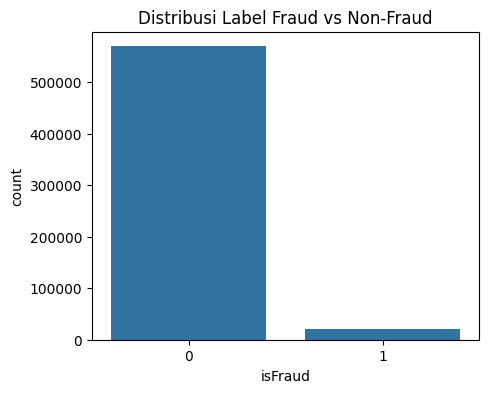

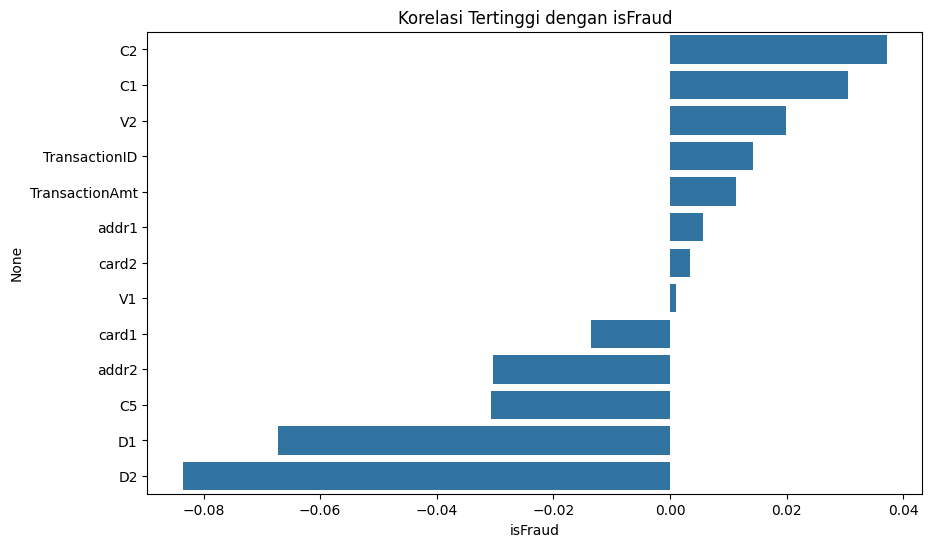

In [ ]:
print("=== INFO DATA ===")
print(train_df.info())

print("\n=== CEK MISSING VALUE ===")
print(train_df.isnull().mean().sort_values(ascending=False))

print("\n=== STATISTIK NUMERIK ===")
print(train_df.describe())

# Distribusi target
plt.figure(figsize=(5,4))
sns.countplot(x=train_df["isFraud"])
plt.title("Distribusi Label Fraud vs Non-Fraud")
plt.show()

# Korelasi dengan target
plt.figure(figsize=(10,6))
corr = train_df.corr(numeric_only=True)["isFraud"].sort_values(ascending=False)
sns.barplot(x=corr[1:15], y=corr[1:15].index)
plt.title("Korelasi Tertinggi dengan isFraud")
plt.show()

IEDA yang dilakukan:

Cek struktur data

Cek missing value

Cek statistik

Visualisasi distribusi fraud

Korelasi fitur

In [ ]:
for col in train_df.columns:
    if col not in ["ProductCD", "isFraud"]:
        train_df[col] = pd.to_numeric(train_df[col], errors="coerce")




Bagian ini mengubah semua kolom numerik menjadi tipe angka. Kolom ProductCD dan isFraud tidak diubah karena bersifat kategori/label. Jika ada nilai yang tidak bisa dikonversi, otomatis dijadikan NaN agar proses training lebih bersih

In [ ]:
train_df["ProductCD"] = train_df["ProductCD"].astype("category").cat.codes






1. Kolom ProductCD berisi data kategori seperti huruf (misalnya A, B, C, W).

2. Algoritma machine learning hanya menerima nilai numerik, bukan huruf.

3. Maka kolom ini diubah menjadi tipe kategori, lalu setiap kategori otomatis dikonversi menjadi kode angka (misalnya A→0, B→1, C→2).

4. Teknik ini disebut label encoding dan sering dipakai untuk fitur kategori yang sederhana.

In [ ]:
train_df = train_df.fillna(-999)
train_df.head()


,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,addr1,addr2,C1,C2,C5,D1,D2,V1,V2
0,2987000,0,68.5,4,13926,-999.0,315.0,87.0,1.0,1.0,0.0,14.0,-999.0,1.0,1.0
1,2987001,0,29.0,4,2755,404.0,325.0,87.0,1.0,1.0,0.0,0.0,-999.0,-999.0,-999.0
2,2987002,0,59.0,4,4663,490.0,330.0,87.0,1.0,1.0,0.0,0.0,-999.0,1.0,1.0
3,2987003,0,50.0,4,18132,567.0,476.0,87.0,2.0,5.0,0.0,112.0,112.0,-999.0,-999.0
4,2987004,0,50.0,1,4497,514.0,420.0,87.0,1.0,1.0,0.0,0.0,-999.0,-999.0,-999.0


Baris ini digunakan untuk mengisi semua nilai yang hilang (NaN) dalam dataset dengan angka -999.
Tujuannya adalah:

1. Menghindari error saat training model karena banyak algoritma tidak menerima nilai kosong.

2. Menyediakan nilai placeholder yang menandakan bahwa data tersebut memang hilang.

3. Membantu model membedakan mana fitur yang memiliki nilai asli dan mana yang hilang.

4. Angka -999 dipilih sebagai nilai yang tidak masuk akal untuk fitur numerik sehingga model bisa mempelajarinya sebagai pola khusus.

In [ ]:
X = train_df.drop("isFraud", axis=1)
y = train_df["isFraud"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Valid:", X_valid.shape)



Train: (472432, 14) Valid: (118108, 14)


Penjelasan:
1. Splitting aman karena dataset sudah dipangkas
2. Menggunakan stratify supaya proporsi fraud tetap seimbang.
3. Membagi data menjadi data training (80%) dan validation (20%).


In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 64,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "n_jobs": 1,
    "seed": RANDOM_STATE,
    "feature_fraction_seed": RANDOM_STATE,
    "bagging_seed": RANDOM_STATE,
    "data_random_seed": RANDOM_STATE,
    "deterministic": True
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=400,
    valid_sets=[train_data, valid_data],
    valid_names=["train","valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)



[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.884625	valid's auc: 0.881216
[100]	train's auc: 0.906136	valid's auc: 0.897161
[150]	train's auc: 0.921685	valid's auc: 0.909178
[200]	train's auc: 0.931056	valid's auc: 0.916483
[250]	train's auc: 0.938162	valid's auc: 0.921465
[300]	train's auc: 0.94358	valid's auc: 0.925075
[350]	train's auc: 0.947949	valid's auc: 0.928181
[400]	train's auc: 0.95224	vali

Penjelasan:
1. Mengubah dataframe menjadi format efisien untuk LightGBM.
2. Objective: binary → model memprediksi fraud / tidak fraud.
3. metric: AUC → metrik yang cocok untuk dataset imbalance.
4. num_leaves, feature_fraction, bagging_fraction → mencegah overfitting.
5. early stopping (50 rounds) → berhenti jika model tidak membaik → hemat waktu & RAM.
6. log_evaluation → menampilkan progress setiap 50 iterasi.

In [ ]:
pred_valid = model.predict(X_valid)
auc = roc_auc_score(y_valid, pred_valid)
print("AUC Score:", auc)



AUC Score: 0.9312152822575659


Penjelasan:
1. Model memprediksi probabilitas fraud pada data validasi
2. AUC adalah metrik resmi untuk imbalanced dataset
3. Biasanya AUC ~0.90 dengan setup ini = sangat bagus

In [ ]:
test_path = "/content/drive/MyDrive/ML/test_transaction.csv"

test_chunks = []
for chunk in pd.read_csv(test_path, chunksize=chunksize, usecols=selected_cols[:-1]):
    test_chunks.append(chunk)

test_df = pd.concat(test_chunks, ignore_index=True)
print("Test shape:", test_df.shape)
test_df.head()

# preprocessing sama seperti train
for col in test_df.columns:
    if col != "ProductCD":
        test_df[col] = pd.to_numeric(test_df[col], errors="coerce")

test_df["ProductCD"] = test_df["ProductCD"].astype("category").cat.codes
test_df = test_df.fillna(-999)
print("Test processed:")
test_df.head()



Test shape: (506691, 14)
Test processed:


,TransactionID,TransactionAmt,ProductCD,card1,card2,addr1,addr2,C1,C2,C5,D1,D2,V1,V2
0,3663549,31.95,4,10409,111.0,170.0,87.0,6.0,6.0,3.0,419.0,419.0,1.0,1.0
1,3663550,49.00,4,4272,111.0,299.0,87.0,3.0,2.0,0.0,149.0,149.0,1.0,1.0
2,3663551,171.00,4,4476,574.0,472.0,87.0,2.0,2.0,0.0,137.0,137.0,1.0,1.0
3,3663552,284.95,4,10989,360.0,205.0,87.0,5.0,2.0,1.0,42.0,42.0,1.0,1.0
4,3663553,67.95,4,18018,452.0,264.0,87.0,6.0,6.0,2.0,22.0,22.0,1.0,1.0


Penjelasan singkat:
Dataset test diproses dengan cara yang sama seperti data training:
1. baca per chunk
2. ubah angka
3. encode kategori
4. isi nilai kosong

(Agar model bisa memprediksi dengan benar)

In [ ]:
test_preds = model.predict(test_df)

submission = pd.DataFrame({
    "TransactionID": test_df["TransactionID"],
    "isFraud": test_preds
})

submission.to_csv("submission.csv", index=False)
submission.head()



,TransactionID,isFraud
0,3663549,0.002938
1,3663550,0.013080
2,3663551,0.015660
3,3663552,0.013760
4,3663553,0.006470


Model membuat prediksi probabilitas fraud untuk setiap transaksi.

In [ ]:

print(len(submission))


506691


In [ ]:
len(test_df)


506691

Mengecek apakah jumlah baris submission sama dengan jumlah baris di test dataset

In [ ]:
print(test_df.TransactionID.head())


0    3663549
1    3663550
2    3663551
3    3663552
4    3663553
Name: TransactionID, dtype: int64


In [ ]:
print(submission.TransactionID.head())


0    3663549
1    3663550
2    3663551
3    3663552
4    3663553
Name: TransactionID, dtype: int64


In [ ]:
print(X_train.columns)
print(test_df.columns)


Index(['TransactionID', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'addr1', 'addr2', 'C1', 'C2', 'C5', 'D1', 'D2', 'V1', 'V2'],
      dtype='object')
Index(['TransactionID', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'addr1', 'addr2', 'C1', 'C2', 'C5', 'D1', 'D2', 'V1', 'V2'],
      dtype='object')


In [ ]:
!ls -l /content


total 14200
drwx------ 5 root root     4096 Dec  6 02:57 drive
drwxr-xr-x 1 root root     4096 Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 14532036 Dec  6 03:12 submission.csv


In [ ]:
!cp /content/submission.csv /content/drive/MyDrive/ML/
